<a href="https://colab.research.google.com/github/kelsingo/CASTICaD/blob/main/SVMFramework_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kelsingo_brainnetome_to_yeo7_path = kagglehub.dataset_download('kelsingo/brainnetome-to-yeo7')
kelsingo_brainnetome_path = kagglehub.dataset_download('kelsingo/brainnetome')
kelsingo_lemon_mri_path = kagglehub.dataset_download('kelsingo/lemon-mri')

print('Data source import complete.')


100%|██████████| 1.63k/1.63k [00:00<00:00, 3.03MB/s]

Extracting files...


100%|██████████| 42.4k/42.4k [00:00<00:00, 16.0MB/s]

Extracting files...


100%|██████████| 539M/539M [00:08<00:00, 64.3MB/s]

Extracting files...


Data source import complete.


# Model Construction

In [ ]:
pip install scikit-learn==1.6.1 imbalanced-learn

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Mamba

In [ ]:
!pip install mamba-ssm --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.5-cp312-cp312-linux_x86_64.whl size=532566033 sha256=c8b65fcabfb49a94456c9971619007218e4073f19a84fb6b3894f33d43bee4a1
  Stored in directory: /root/.cache/pip/wheels/21/55/c4/85b634055d6a9b599d27f5cbeacf353c6c532d8e2d8769960b
Successfully built mamba-ssm


In [ ]:
from mamba_ssm import Mamba
import torch
import torch.nn as nn

class MambaModule(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mb = Mamba(d_model=input_dim, d_state=16, d_conv=4, expand=2)
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        out = self.mb(x)
        return out

## FC Calculation

In [ ]:
!pip install nilearn nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 98.0 MB/s eta 0:00:00


In [ ]:
from nilearn.connectome import ConnectivityMeasure

def FC_compute(ts):
    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        standardize="zscore_sample"
    )

    fc = correlation_measure.fit_transform([ts])[0]
    return fc

## General Blocks

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_mult=4, dropout=0.1):
        super().__init__()
        self.ffw = nn.Sequential(
            nn.Linear(dim, hidden_mult*dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_mult*dim, dim),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.ffw(x)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.0, batch_first=True):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=batch_first)
        self.drop1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn   = FeedForward(dim, dropout=dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None, need_weights=False):
        qkv_norm = self.norm1(x)
        ctx, attn_w = self.attn(
            query=qkv_norm,
            key=qkv_norm,
            value=qkv_norm,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask, need_weights=need_weights
        )
        x = x + self.drop1(ctx)
        x = x + self.drop2(self.ffn(self.norm2(x))) # residual connection
        return (x, attn_w) if need_weights else x

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.0, batch_first=True):
        super().__init__()
        self.norm_q = nn.LayerNorm(dim)
        self.norm_kv = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=batch_first)
        self.drop1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn   = FeedForward(dim, dropout=dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, q, kv, attn_mask=None, key_padding_mask=None, need_weights=False):
        q_norm = self.norm_q(q)
        kv_norm = self.norm_kv(kv)
        ctx, attn_w = self.attn(
            query=q_norm,
            key=kv_norm,
            value=kv_norm,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights
        )
        x = q + self.drop1(ctx)
        x = x + self.drop2(self.ffn(self.norm2(x))) # residual connection
        return (x, attn_w) if need_weights else x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.0):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.mlp(x)


### Encoder-Decoder Blocks

In [ ]:
class SCEncoder(nn.Module):
    def __init__(self, num_nodes, dim, layers=1, heads=8, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_nodes, dim)
        self.blocks = nn.ModuleList([SelfAttention(dim, heads, dropout) for _ in range(layers)])
        self.out_norm = nn.LayerNorm(dim)

    def forward(self, sc):
        x = self.input_proj(sc)
        for blk in self.blocks:
            x = blk(x)
        return self.out_norm(x)

In [ ]:
class FCDecoder(nn.Module):
    def __init__(self, num_nodes, dim, layers=1, heads=8, dropout=0.1,
                 predict_activation='tanh', mask_prob=0.1, seed=42):
        super().__init__()
        self.num_heads = heads
        self.input_proj = nn.Linear(num_nodes, dim)
        self.self_blocks = nn.ModuleList([SelfAttention(dim, heads, dropout) for _ in range(layers)])
        self.cross_blocks = nn.ModuleList([CrossAttention(dim, heads, dropout)])
        self.row_head = nn.Linear(dim, num_nodes)
        self.predict_activation = predict_activation
        self.mask_prob = mask_prob
        self.seed = seed

    def forward(self, fc, sc, target_fc=None):
        B, N, _ = fc.shape

        fc_mask = (torch.rand(B, N, N, device=fc.device) < self.mask_prob)
        diag_mask = torch.eye(N, device=fc.device, dtype=torch.bool).unsqueeze(0)
        fc_mask = fc_mask & (~diag_mask)

        q = self.input_proj(fc)

        attn_mask_float = fc_mask.float() * -1e9
        attn_mask_float = attn_mask_float.repeat(self.num_heads, 1, 1)

        for blk in self.self_blocks:
            q = blk(q, attn_mask=attn_mask_float, need_weights=False)

        for blk in self.cross_blocks:
            q = blk(q, sc, need_weights=False)

        rows = self.row_head(q)
        if self.predict_activation == 'tanh':
            rows = torch.tanh(rows)

        fc_pred = 0.5 * (rows + rows.transpose(1, 2))
        fc_pred = fc_pred.masked_fill(diag_mask, 0.0)

        return fc_pred

# Training

## Data

In [ ]:
ts_path = os.path.join(kelsingo_lemon_mri_path, "ts", "ts")
sc_path = os.path.join(kelsingo_lemon_mri_path, "SC", "SC", "prob")
fc_path = os.path.join(kelsingo_lemon_mri_path, "FC", "FC")
metadata_path = os.path.join(kelsingo_lemon_mri_path, "participants.tsv")

# kelsingo_brainnetome_to_yeo7_path = kagglehub.dataset_download('kelsingo/brainnetome-to-yeo7')
# kelsingo_brainnetome_path = kagglehub.dataset_download('kelsingo/brainnetome')
# kelsingo_lemon_mri_path = kagglehub.dataset_download('kelsingo/lemon-mri')

In [ ]:
df = pd.read_csv(metadata_path, sep="\t", nrows=212)
df.columns = df.columns.str.strip()
remove_ids = ["sub-032457", "sub-032435", "sub-032509", "sub-032370"]
remove_rows = df[df['ID'].isin(remove_ids)].index
print(f"Remove row {remove_rows}")
df = df.drop(remove_rows)
print(df.columns)
print(len(df))

Remove row Index([67, 132, 152, 202], dtype='int64')
Index(['ID', 'Gender_ 1=female_2=male', 'Age'], dtype='object')
208


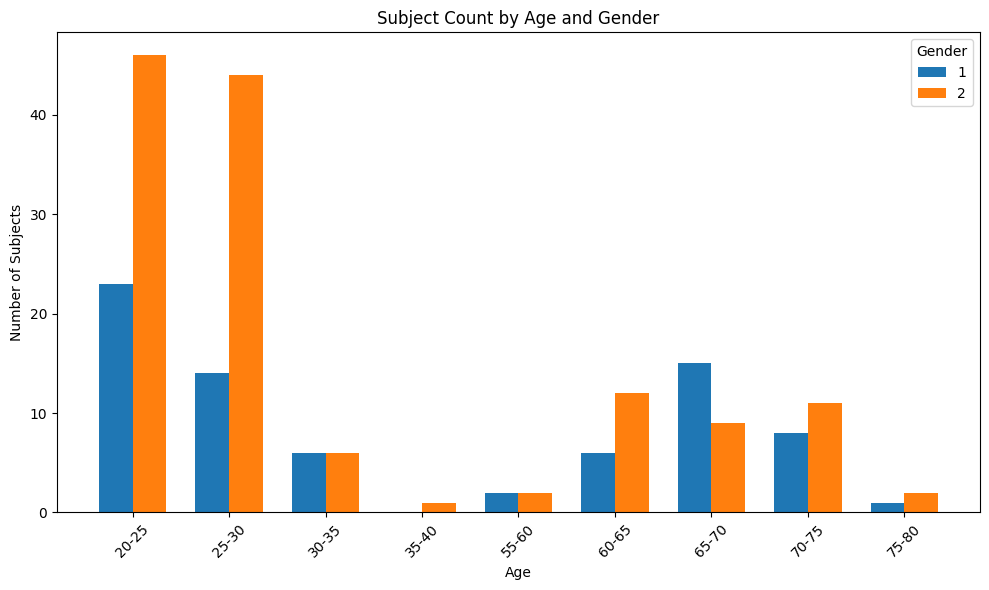

In [ ]:
grouped = df.groupby(['Age', 'Gender_ 1=female_2=male']).size().unstack(fill_value=0)

ages = grouped.index
genders = grouped.columns
x = np.arange(len(ages))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

for i, gender in enumerate(genders):
    ax.bar(x + i * bar_width, grouped[gender], width=bar_width, label=gender)

# Formatting
ax.set_xlabel('Age')
ax.set_ylabel('Number of Subjects')
ax.set_title('Subject Count by Age and Gender')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(ages, rotation=45)
ax.legend(title='Gender')
plt.tight_layout()
plt.show()

In [ ]:
file_path = os.path.join(ts_path, "sub-032302_ts.txt")
data = np.loadtxt(file_path)
data = data.transpose()
print(data.shape)

(246, 652)


In [ ]:
def age_group_to_class(age_str):
    if age_str == "20-25" or age_str == "25-30" or age_str == "30-35" or age_str == "35-40":
        return 0
    elif age_str == "60-65" or age_str == "65-70" or age_str == "70-75" or age_str == "75-80" or age_str == "55-60":
        return 1
    raise ValueError(f"Unexpected age group: {age_str}")

id_to_label = {row["ID"]: age_group_to_class(row["Age"]) for _, row in df.iterrows()}
missing_ids = set()
y_data, ts_data, sc_data, fc_data = [], [], [], []

subj_ids = df["ID"].tolist()
print(subj_ids)

['sub-032301', 'sub-032302', 'sub-032303', 'sub-032304', 'sub-032305', 'sub-032306', 'sub-032307', 'sub-032308', 'sub-032309', 'sub-032310', 'sub-032311', 'sub-032312', 'sub-032313', 'sub-032314', 'sub-032315', 'sub-032316', 'sub-032317', 'sub-032318', 'sub-032319', 'sub-032320', 'sub-032321', 'sub-032322', 'sub-032323', 'sub-032324', 'sub-032325', 'sub-032326', 'sub-032327', 'sub-032328', 'sub-032329', 'sub-032330', 'sub-032331', 'sub-032332', 'sub-032333', 'sub-032334', 'sub-032335', 'sub-032336', 'sub-032337', 'sub-032338', 'sub-032340', 'sub-032342', 'sub-032343', 'sub-032344', 'sub-032345', 'sub-032346', 'sub-032347', 'sub-032348', 'sub-032349', 'sub-032350', 'sub-032351', 'sub-032352', 'sub-032353', 'sub-032354', 'sub-032355', 'sub-032356', 'sub-032357', 'sub-032358', 'sub-032359', 'sub-032360', 'sub-032361', 'sub-032362', 'sub-032363', 'sub-032364', 'sub-032365', 'sub-032366', 'sub-032367', 'sub-032368', 'sub-032369', 'sub-032371', 'sub-032372', 'sub-032373', 'sub-032374', 'sub-

In [ ]:
print(len(subj_ids))

208


In [ ]:
import torch

for subj_id in subj_ids:

    y_data.append(id_to_label[subj_id])
    # time series
    ts_fname = f"{subj_id}_ts.txt"
    ts_fpath = os.path.join(ts_path, ts_fname)
    if os.path.isfile(ts_fpath):
        df = pd.read_csv(ts_fpath, sep='\t', header=None)
        ts_data.append(torch.tensor(df.values, dtype=torch.float32))
    # SC
    sc_fname = f"{subj_id}_prob.csv"
    sc_fpath = os.path.join(sc_path, sc_fname)
    if os.path.isfile(sc_fpath):
        df = pd.read_csv(sc_fpath, header=None)
        df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
        sc_tensor = torch.tensor(df.values, dtype=torch.float32)

        # Min-max normalization per subject
        sc_min = sc_tensor.min()
        sc_max = sc_tensor.max()
        if sc_max > sc_min:
            sc_tensor = (sc_tensor - sc_min) / (sc_max - sc_min)
        else:
            sc_tensor = torch.zeros_like(sc_tensor)  # fallback if constant matrix

        sc_data.append(sc_tensor)

    # FC
    fc_fname = f"{subj_id}_FC.csv"
    fc_fpath = os.path.join(fc_path, fc_fname)
    if os.path.isfile(fc_fpath):
        df = pd.read_csv(fc_fpath, header=None)
        df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
        fc_data.append(torch.tensor(df.values, dtype=torch.float32))

TS = torch.stack(ts_data)
SC = torch.stack(sc_data)
FC = torch.stack(fc_data)
y = torch.tensor(y_data, dtype=torch.long)
print(f"TS shape: {TS.shape}, SC shape: {SC.shape}, FC shape: {FC.shape}, y shape: {y.shape}")
print(f"Class distribution: {torch.bincount(y)}")

TS shape: torch.Size([208, 652, 246]), SC shape: torch.Size([208, 246, 246]), FC shape: torch.Size([208, 246, 246]), y shape: torch.Size([208])
Class distribution: tensor([140,  68])


In [ ]:
class BrainAgesDataset(Dataset):
    def __init__(self, TS, SC, y):
        self.TS = TS
        self.SC = SC
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.TS[idx], self.SC[idx], self.y[idx]

In [ ]:
# from collections import Counter
# from torch.utils.data import DataLoader, WeightedRandomSampler
# from sklearn.model_selection import train_test_split
# import torch

# # --- Split dataset (original data only, no SMOTE) ---
# indices = np.arange(len(y))
# trainval_idx, test_idx, y_trainval, y_test = train_test_split(
#     indices, y.numpy(), test_size=0.15, stratify=y.numpy(), random_state=42
# )

# train_idx, val_idx, y_train, y_val = train_test_split(
#     trainval_idx, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
# )

# # --- Build tensors for splits ---
# train_TS = TS[train_idx]
# train_SC = SC[train_idx]
# train_y  = y[train_idx]

# val_TS = TS[val_idx]
# val_SC = SC[val_idx]
# val_y  = y[val_idx]

# test_TS = TS[test_idx]
# test_SC = SC[test_idx]
# test_y  = y[test_idx]

# print("Train distribution:", Counter(train_y.tolist()))
# print("Val distribution:", Counter(val_y.tolist()))
# print("Test distribution:", Counter(test_y.tolist()))

# X_train = BrainAgesDataset(train_TS, train_SC, train_y)
# X_val   = BrainAgesDataset(val_TS, val_SC, val_y)
# X_test  = BrainAgesDataset(test_TS, test_SC, test_y)

# class_sample_count = torch.tensor([(train_y == t).sum() for t in torch.unique(train_y)], dtype=torch.float)
# weights = 1. / class_sample_count
# samples_weight = torch.tensor([weights[t] for t in train_y], dtype=torch.float)
# sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

# batch_size = 16
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)  # use shuffle OR sampler
# val_loader   = DataLoader(X_val, batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(X_test, batch_size=batch_size, shuffle=False)

# print(f"Train size: {len(train_y)}, Val size: {len(val_y)}, Test size: {len(test_y)}")
# print("Train class distribution:", torch.bincount(train_y))
# print("Val class distribution:", torch.bincount(val_y))
# print("Test class distribution:", torch.bincount(test_y))


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import torch

# --- Split first on original dataset (NO SMOTE yet) ---
indices = np.arange(len(y))
trainval_idx, test_idx, y_trainval_np, y_test_np = train_test_split(
    indices, y.numpy(), test_size=0.15, stratify=y.numpy(), random_state=42
)

train_idx, val_idx, y_train_np, y_val_np = train_test_split(
    trainval_idx, y_trainval_np, test_size=0.1765, stratify=y_trainval_np, random_state=42
)

# --- Prepare flattened features ---
TS_flat = TS.reshape(TS.shape[0], -1).numpy()
SC_flat = SC.reshape(SC.shape[0], -1).numpy()
FC_flat = FC.reshape(FC.shape[0], -1).numpy()
X = np.concatenate([TS_flat, SC_flat, FC_flat], axis=1)
y_np = y.numpy()

# --- Apply SMOTE ONLY on training set ---
X_train = X[train_idx]
y_train = y_np[train_idx]

print("Before SMOTE (train):", Counter(y_train))

smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy={1:55})  # k=1 if few samples
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE (train):", Counter(y_train_res))

# --- Reshape back training set ---
ts_size = TS_flat.shape[1]
sc_size = SC_flat.shape[1]
fc_size = FC_flat.shape[1]

train_TS = torch.tensor(X_train_res[:, :ts_size]).reshape(-1, TS.shape[1], TS.shape[2])
train_SC = torch.tensor(X_train_res[:, ts_size:ts_size+sc_size]).reshape(-1, SC.shape[1], SC.shape[2])
train_y  = torch.tensor(y_train_res, dtype=torch.long)

# --- Validation & test sets (untouched, no SMOTE) ---
val_TS = TS[val_idx]
val_SC = SC[val_idx]
val_y  = torch.tensor(y_val_np, dtype=torch.long)

test_TS = TS[test_idx]
test_SC = SC[test_idx]
test_y  = torch.tensor(y_test_np, dtype=torch.long)

# --- Dataset wrappers ---
X_train = BrainAgesDataset(train_TS, train_SC, train_y)
X_val   = BrainAgesDataset(val_TS, val_SC, val_y)
X_test  = BrainAgesDataset(test_TS, test_SC, test_y)

# --- Weighted sampler for train ---
class_sample_count = torch.tensor([(train_y == t).sum() for t in torch.unique(train_y)], dtype=torch.float)
weights = 1. / class_sample_count
samples_weight = torch.tensor([weights[t] for t in train_y], dtype=torch.float)
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

batch_size = 32
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(X_val, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(X_test, batch_size=batch_size, shuffle=False)

# --- Check distributions ---
print(f"Train size: {len(train_y)}, Val size: {len(val_y)}, Test size: {len(test_y)}")
print("Train class distribution:", torch.bincount(train_y))
print("Val class distribution:", torch.bincount(val_y))
print("Test class distribution:", torch.bincount(test_y))


Before SMOTE (train): Counter({np.int64(0): 97, np.int64(1): 47})
After SMOTE (train): Counter({np.int64(0): 97, np.int64(1): 55})
Train size: 152, Val size: 32, Test size: 32
Train class distribution: tensor([97, 55])
Val class distribution: tensor([21, 11])
Test class distribution: tensor([22, 10])


## Pretraining

In [ ]:
embed_dim = 2048
num_epochs = 50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mamba = MambaModule(input_dim=246)
mamba.mb = mamba.mb.to(device)
mamba = mamba.to(device)
encoder = SCEncoder(num_nodes=246, dim=embed_dim).to(device)
decoder = FCDecoder(num_nodes=246, dim=embed_dim).to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    list(mamba.parameters()) +
    list(encoder.parameters()) +
    list(decoder.parameters()), lr=1e-4
)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    mamba.train()
    encoder.train()
    decoder.train()

    train_epoch_loss = 0.0

    for TS_batch, SC_batch, _ in train_loader:
        TS_batch, SC_batch = TS_batch.to(device), SC_batch.to(device)

        optimizer.zero_grad()

        ts_repr = mamba(TS_batch)
        SC_batch = encoder(SC_batch)
        FC_batch_list = [FC_compute(ts.detach().cpu().numpy()) for ts in ts_repr]
        FC_batch = torch.tensor(np.array(FC_batch_list), dtype=torch.float32, device=device)

        sc_fc_fusion = decoder(FC_batch, SC_batch)


        loss = criterion(sc_fc_fusion, FC_batch)
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    mamba.eval()
    encoder.eval()
    decoder.eval()

    val_epoch_loss = 0.0

    with torch.no_grad():
        for TS_batch, SC_batch, _ in val_loader:
            TS_batch, SC_batch = TS_batch.to(device), SC_batch.to(device)

            ts_repr = mamba(TS_batch)
            SC_batch = encoder(SC_batch)
            FC_batch_list = [FC_compute(ts.detach().cpu().numpy()) for ts in ts_repr]
            FC_batch = torch.tensor(np.array(FC_batch_list), dtype=torch.float32, device=device)

            sc_fc_fusion = decoder(FC_batch, SC_batch)

            loss = criterion(sc_fc_fusion, FC_batch)
            val_epoch_loss += loss.item()

    train_losses.append(train_epoch_loss / len(train_loader))
    val_losses.append(val_epoch_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

Epoch 1/50 | Train Loss: 0.1306 | Val Loss: 0.0656
Epoch 2/50 | Train Loss: 0.0528 | Val Loss: 0.0324
Epoch 3/50 | Train Loss: 0.0327 | Val Loss: 0.0223
Epoch 4/50 | Train Loss: 0.0238 | Val Loss: 0.0178
Epoch 5/50 | Train Loss: 0.0188 | Val Loss: 0.0143
Epoch 6/50 | Train Loss: 0.0157 | Val Loss: 0.0123
Epoch 7/50 | Train Loss: 0.0135 | Val Loss: 0.0109
Epoch 8/50 | Train Loss: 0.0121 | Val Loss: 0.0098
Epoch 9/50 | Train Loss: 0.0111 | Val Loss: 0.0092
Epoch 10/50 | Train Loss: 0.0103 | Val Loss: 0.0086
Epoch 11/50 | Train Loss: 0.0097 | Val Loss: 0.0081
Epoch 12/50 | Train Loss: 0.0092 | Val Loss: 0.0077
Epoch 13/50 | Train Loss: 0.0088 | Val Loss: 0.0074
Epoch 14/50 | Train Loss: 0.0085 | Val Loss: 0.0072
Epoch 15/50 | Train Loss: 0.0083 | Val Loss: 0.0069
Epoch 16/50 | Train Loss: 0.0080 | Val Loss: 0.0068
Epoch 17/50 | Train Loss: 0.0078 | Val Loss: 0.0066
Epoch 18/50 | Train Loss: 0.0077 | Val Loss: 0.0065
Epoch 19/50 | Train Loss: 0.0075 | Val Loss: 0.0063
Epoch 20/50 | Train L

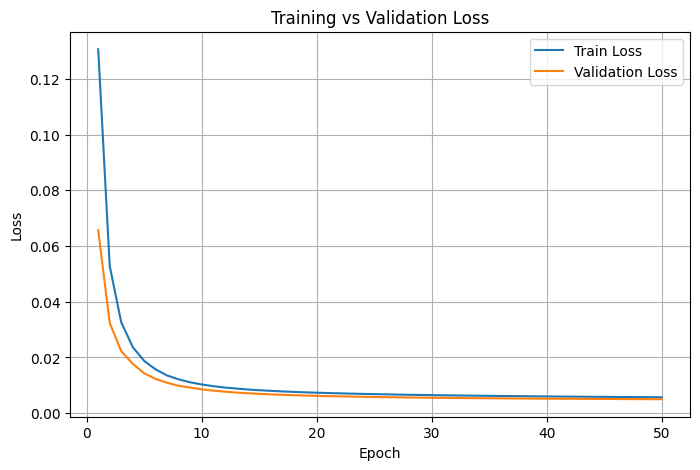

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mamba.eval()
encoder.eval()
all_fc_train = []
all_sc_train = []
with torch.no_grad():
    for TS_batch, SC_batch, _ in train_loader:
        sc_repr = encoder(SC_batch.to(device))
        all_sc_train.append(sc_repr.cpu())
        ts_repr = mamba(TS_batch.to(device))
        for ts in ts_repr:
            ts_np = ts.cpu().numpy()
            fc = FC_compute(ts_np)
            all_fc_train.append(torch.tensor(fc))
SC_train_embeddings = torch.cat(all_sc_train, dim=0)
FC_train_embeddings = torch.stack(all_fc_train, dim=0)

all_fc_val = []
all_sc_val = []
with torch.no_grad():
    for TS_batch, SC_batch, _ in val_loader:
        sc_repr = encoder(SC_batch.to(device))
        all_sc_val.append(sc_repr.cpu())
        ts_repr = mamba(TS_batch.to(device))
        for ts in ts_repr:
            ts_np = ts.cpu().numpy()
            fc = FC_compute(ts_np)
            all_fc_val.append(torch.tensor(fc))
FC_val_embeddings = torch.stack(all_fc_val, dim=0)
SC_val_embeddings = torch.cat(all_sc_val, dim=0)

In [ ]:
# After embedding extraction, explicitly pair them
train_embeddings_dataset = TensorDataset(
    FC_train_embeddings.to(device),
    SC_train_embeddings.to(device),
    train_y.to(device)
)
train_embeddings_loader = DataLoader(train_embeddings_dataset, batch_size=batch_size, shuffle=True)


## Classification

In [ ]:
class FCEncoder_Finetune(nn.Module):
    def __init__(self, num_nodes, dim, layers=1, heads=8, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(num_nodes, dim)
        self.self_blocks  = nn.ModuleList([SelfAttention(dim, heads, dropout) for _ in range(layers)])
        self.cross_blocks = nn.ModuleList([CrossAttention(dim, heads, dropout)])
        self.row_head = nn.Linear(dim, 246)
        self.layer_norm = nn.LayerNorm(246)

    def forward(self, fc, sc):
        x = self.input_proj(fc)
        for blk in self.self_blocks:
            x = blk(x)
        for blk in self.cross_blocks:
            x = blk(x, sc)

        rows = self.row_head(x)
        rows = 0.5 * (rows + rows.transpose(1, 2))

        fc_out = fc + rows
        fc_out = self.layer_norm(fc_out)
        return fc_out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearSVM(nn.Module):
    def __init__(self, input_dim, num_classes, num_features=246):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(input_dim, num_features), requires_grad=False)
        self.b = nn.Parameter(2 * torch.pi * torch.rand(num_features), requires_grad=False)
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        z = torch.cos(x @ self.omega + self.b) * (2.0 / self.omega.shape[1])**0.5
        return self.fc(z)

In [ ]:
def svm_qp_loss(outputs, targets, model, C=1.0, margin=1.0, class_weights=None):
    """
    SVM primal loss = 0.5 * ||w||^2 + C * hinge_loss
    outputs: raw model scores [B, 2]
    targets: ground truth labels [B] in {0,1}
    model: the classifier (to extract w)
    """
    scores = outputs[:, 1] - outputs[:, 0]
    y = 2 * targets.float() - 1

    hinge = torch.clamp(margin - scores * y, min=0)

    if class_weights is not None:
        sample_weights = class_weights[targets]
        hinge_loss = (hinge * sample_weights).mean()
    else:
        hinge_loss = hinge.mean()

    w = model.svm_head.fc.weight  # shape [2, D]
    w_diff = w[1] - w[0]
    reg_term = 0.5 * torch.norm(w_diff, p=2) ** 2

    # --- total loss ---
    loss = reg_term + C * hinge_loss
    return loss

In [ ]:
class FC_SC_Classifier(nn.Module):
    def __init__(self, num_nodes, dim, proj_dim=246, output_dim=2, layers=1, heads=8, dropout=0.1):
        super().__init__()
        self.fc_encoder = FCEncoder_Finetune(num_nodes, dim, layers, heads, dropout)
        self.row_weights = nn.Parameter(torch.ones(num_nodes) / num_nodes)
        self.svm_head = LinearSVM(proj_dim, output_dim)

    def forward(self, fc, sc):
        x = self.fc_encoder(fc, sc)
        x = F.layer_norm(x, x.shape[1:])
        row_logits = self.svm_head(x)
        weights = F.softmax(self.row_weights, dim=0)   # [N]
        logits = torch.einsum("bnc,n->bc", row_logits, weights)
        return logits

In [ ]:
_train_y = train_y.numpy()
counter = Counter(_train_y)
print("Class distribution:", counter)
N = len(_train_y)
K = len(counter)
class_weights = {cls: N / (count * K) for cls, count in counter.items()}
print("Class weights:", class_weights)
weights_array = np.array([class_weights[0], class_weights[1]])
class_weights_tensor = torch.tensor(weights_array, dtype=torch.float32).to(device)
print("Weights tensor:", class_weights_tensor)

Class distribution: Counter({np.int64(0): 97, np.int64(1): 55})
Class weights: {np.int64(0): 0.7835051546391752, np.int64(1): 1.3818181818181818}
Weights tensor: tensor([0.7835, 1.3818], device='cuda:0')


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FC_SC_Classifier(num_nodes=246, dim=2048, output_dim=2).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
train_losses = []
val_losses = []
patience = 10              # stop if no improvement for 5 epochs
best_val_loss = float("inf")
best_model_state = None
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for fc_batch, sc_batch, labels_batch in train_embeddings_loader:
        # fc_batch = FC_train_embeddings[i:i+batch_size].to(device)
        # sc_batch = SC_train_embeddings[i:i+batch_size].to(device)
        # labels_batch = train_y[i:i+batch_size].long().to(device)

        optimizer.zero_grad()
        outputs = model(fc_batch, sc_batch)
        scores = outputs[:, 1] - outputs[:, 0]
        loss = svm_qp_loss(outputs, labels_batch, model, C=2.0, class_weights=class_weights_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * fc_batch.size(0)

    avg_train_loss = epoch_loss / FC_train_embeddings.size(0)
    train_losses.append(avg_train_loss)

    # --- Validation loop ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i in range(0, FC_val_embeddings.size(0), batch_size):
            fc_batch = FC_val_embeddings[i:i+batch_size].to(device)
            sc_batch = SC_val_embeddings[i:i+batch_size].to(device)
            labels_batch = val_y[i:i+batch_size].long().to(device)

            outputs = model(fc_batch, sc_batch)
            scores = outputs[:, 1] - outputs[:, 0]
            loss = svm_qp_loss(outputs, labels_batch, model, C=2.0)
            val_loss += loss.item() * fc_batch.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

    avg_val_loss = val_loss / FC_val_embeddings.size(0)
    val_losses.append(avg_val_loss)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # save best weights
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model (optional)
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1/100 | Train Loss: 2.2884 | Val Loss: 2.2269 | Val Acc: 0.5625
Epoch 2/100 | Train Loss: 2.2047 | Val Loss: 2.1553 | Val Acc: 0.6562
Epoch 3/100 | Train Loss: 2.1464 | Val Loss: 2.0918 | Val Acc: 0.6562
Epoch 4/100 | Train Loss: 2.1025 | Val Loss: 2.0758 | Val Acc: 0.6562
Epoch 5/100 | Train Loss: 2.0673 | Val Loss: 2.0466 | Val Acc: 0.6562
Epoch 6/100 | Train Loss: 2.0480 | Val Loss: 1.9961 | Val Acc: 0.6562
Epoch 7/100 | Train Loss: 2.0332 | Val Loss: 2.0015 | Val Acc: 0.6562
Epoch 8/100 | Train Loss: 2.0230 | Val Loss: 2.0003 | Val Acc: 0.6562
Epoch 9/100 | Train Loss: 2.0151 | Val Loss: 2.0008 | Val Acc: 0.6562
Epoch 10/100 | Train Loss: 2.0115 | Val Loss: 1.9909 | Val Acc: 0.6562
Epoch 11/100 | Train Loss: 2.0070 | Val Loss: 1.9888 | Val Acc: 0.6562
Epoch 12/100 | Train Loss: 2.0041 | Val Loss: 1.9866 | Val Acc: 0.6562
Epoch 13/100 | Train Loss: 2.0035 | Val Loss: 1.9905 | Val Acc: 0.6562
Epoch 14/100 | Train Loss: 2.0010 | Val Loss: 1.9843 | Val Acc: 0.6562
Epoch 15/100 | 

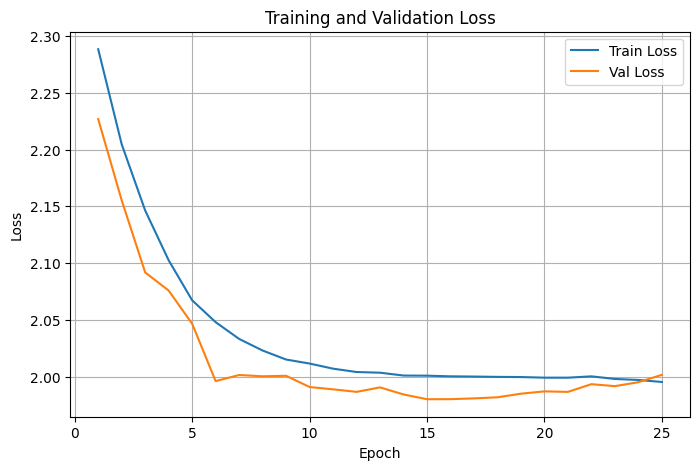

In [ ]:
epochs_ran = len(train_losses)

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_ran+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs_ran+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Testing

In [ ]:
mamba.eval()
encoder.eval()
all_fc_test = []
all_sc_test = []
with torch.no_grad():
    for TS_batch, SC_batch, _ in test_loader:
        sc_repr = encoder(SC_batch.to(device))
        all_sc_test.append(sc_repr.cpu())
        ts_repr = mamba(TS_batch.to(device))
        for ts in ts_repr:
            ts_np = ts.cpu().numpy()
            fc = FC_compute(ts_np)
            all_fc_test.append(torch.tensor(fc))
SC_test_embeddings = torch.cat(all_sc_test, dim=0)
FC_test_embeddings = torch.stack(all_fc_test, dim=0)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for i in range(0, FC_test_embeddings.size(0), batch_size):
        fc_batch = FC_test_embeddings[i:i+batch_size].to(device)
        sc_batch = SC_test_embeddings[i:i+batch_size].to(device)
        labels_batch = test_y[i:i+batch_size].long().to(device)  # make sure labels are long

        outputs = model(fc_batch, sc_batch)
        preds = outputs.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_true.append(labels_batch.cpu())

all_preds = torch.cat(all_preds)
all_true = torch.cat(all_true)

test_acc = (all_preds == all_true).sum().item() / all_true.size(0)
print(f"Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(all_true.numpy(), all_preds.numpy())
print("Confusion Matrix:")
print(cm)

report = classification_report(all_true.numpy(), all_preds.numpy())
print("Classification Report:")
print(report)

Test Accuracy: 0.5938
Confusion Matrix:
[[17  5]
 [ 8  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        22
           1       0.29      0.20      0.24        10

    accuracy                           0.59        32
   macro avg       0.48      0.49      0.48        32
weighted avg       0.56      0.59      0.57        32



In [ ]:
def get_fc_outs(encoder_finetune, FC_embeddings, SC_embeddings, device, batch_size=32):
    encoder_finetune.eval()
    all_fc_outs = []

    with torch.no_grad():
        for i in range(0, FC_embeddings.size(0), batch_size):
            fc_batch = FC_embeddings[i:i+batch_size].to(device)   # [B, N, N]
            sc_batch = SC_embeddings[i:i+batch_size].to(device)   # [B, N, D]

            fc_out_batch = encoder_finetune(fc_batch, sc_batch)   # [B, N, N]
            all_fc_outs.append(fc_out_batch.cpu())

    return torch.cat(all_fc_outs, dim=0)   # [num_subjects, N, N]

# Further Analysis

## Community Detection

In [ ]:
brainnetome_to_yeo7 = "/kaggle/input/brainnetome-to-yeo7/brainnetome_to_yeo7.csv"

In [ ]:
y_all = np.concatenate([y_train_np, y_val_np, y_test_np], axis=0)

In [ ]:
df_map = pd.read_csv(brainnetome_to_yeo7)
df_map["Yeo_7network"]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brainnetome-to-yeo7/brainnetome_to_yeo7.csv'

In [ ]:
df_map["Yeo_7network"].unique()

In [ ]:
modules = []
for i in range(1, 247):
    val = df_map.loc[df_map["index"] == i, "Yeo_7network"].values[0]

    if val == 'Frontoparietal':
        modules.append(0)
    elif val == 'Ventral Attention':
        modules.append(1)
    elif val == 'Default':
        modules.append(2)
    elif val == 'Dorsal Attention':
        modules.append(3)
    elif val == 'Somatomotor':
        modules.append(4)
    elif val == 'Limbic':
        modules.append(5)
    elif val == 'Visual':
        modules.append(6)
    elif val == 'SCGM':
        modules.append(7)
modules = np.array(modules)
print(modules.shape)
print(modules)

### Pretraining

In [ ]:
mamba.eval()
for param in mamba.parameters():
    param.requires_grad = False
real_train_TS = TS[train_idx]
all_TS = torch.cat([real_train_TS, val_TS, test_TS], dim=0).to(device)


# Generate FC representations
all_FC_list = []
with torch.no_grad():  # no gradient needed
    for ts in all_TS:
        ts = ts.unsqueeze(0)  # add batch dimension
        ts_repr = mamba(ts)   # forward pass through mamba
        for ts in ts_repr:
            ts_np = ts.cpu().numpy()
            fc = FC_compute(ts_np)
            all_FC_list.append(fc)

# Convert to tensor if needed
all_FC = torch.tensor(all_FC_list, dtype=torch.float32)
mean_FC = all_FC.mean(dim=0)  # shape: [246, 246]
print(all_FC.shape)
print(mean_FC.shape)

In [ ]:
print(mean_FC)

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

N_total = all_FC.shape[0]
n_clusters = 7  # only for cortical nodes
n_runs = 50  # number of KMeans runs per subject
cortical_nodes = 210  # nodes 0-209
subcortical_nodes = 246 - cortical_nodes  # nodes 210-245

adj = all_FC[subj]  # (246, 246)
roi_features = adj[:cortical_nodes, :cortical_nodes]  # only cortical nodes

# Step 1: Run KMeans multiple times
all_run_labels = []
for run in range(n_runs):
    kmeans = KMeans(n_clusters=n_clusters, random_state=run, n_init=10)
    labels = kmeans.fit_predict(roi_features)
    all_run_labels.append(labels)
all_run_labels = np.array(all_run_labels)  # (n_runs, cortical_nodes)

# Step 2: Build co-association matrix (vectorized)
coassoc = np.zeros((cortical_nodes, cortical_nodes))
for run_labels in all_run_labels:
    mask = run_labels[:, None] == run_labels[None, :]
    coassoc += mask.astype(float)
coassoc /= n_runs  # normalize to [0,1]

# Step 3: Consensus clustering using hierarchical clustering
distance_matrix = 1 - coassoc
condensed_distance = squareform(distance_matrix, checks=False)
Z = linkage(condensed_distance, method='average')
consensus_labels_cortical = fcluster(Z, t=n_clusters, criterion='maxclust') - 1  # 0-indexed

# Step 4: Combine cortical + subcortical nodes
consensus_labels = np.zeros(246, dtype=int)
consensus_labels[:cortical_nodes] = consensus_labels_cortical
consensus_labels[cortical_nodes:] = n_clusters  # assign fixed label to subcortical nodes
print("Consensus cluster labels shape:", consensus_labels.shape)

In [ ]:
print(consensus_labels)

In [ ]:
real_sc_train = SC[train_idx].to(device)
real_ts_train = real_train_TS.to(device)

all_fc_real_train = []
all_sc_real_train = []

with torch.no_grad():
    sc_repr = encoder(real_sc_train)
    all_sc_real_train.append(sc_repr.cpu())

    ts_repr = mamba(real_ts_train)
    for ts in ts_repr:
        ts_np = ts.cpu().numpy()
        fc = FC_compute(ts_np)
        all_fc_real_train.append(torch.tensor(fc))

SC_real_train_embeddings = torch.cat(all_sc_real_train, dim=0)
FC_real_train_embeddings = torch.stack(all_fc_real_train, dim=0)

In [ ]:
# Use the trained classifier’s encoder
encoder_finetune = model.fc_encoder

fc_out_train = get_fc_outs(encoder_finetune, FC_real_train_embeddings, SC_real_train_embeddings, device)
fc_out_val   = get_fc_outs(encoder_finetune, FC_val_embeddings, SC_val_embeddings, device)
fc_out_test  = get_fc_outs(encoder_finetune, FC_test_embeddings, SC_test_embeddings, device)

print("Train fc_out:", fc_out_train.shape)  # (N_train, 246, 246)
print("Val fc_out:",   fc_out_val.shape)    # (N_val,   246, 246)
print("Test fc_out:",  fc_out_test.shape)   # (N_test,  246, 246)

In [ ]:
all_FC = torch.cat([fc_out_train, fc_out_val, fc_out_test], dim=0)
print(all_FC.shape)
mean_FC = all_FC.mean(dim=0)  # shape: [246, 246]
print(all_FC.shape)
print(mean_FC.shape)

In [ ]:
print(mean_FC)

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import numpy as np

n_clusters = 7  # only for cortical nodes
n_runs = 50     # number of KMeans runs
cortical_nodes = 210
subcortical_nodes = 246 - cortical_nodes

# Step 0: get cortical adjacency
roi_features = mean_FC[:cortical_nodes, :cortical_nodes]  # (210, 210)

# Step 1: Run KMeans multiple times
all_run_labels = []
for run in range(n_runs):
    kmeans = KMeans(n_clusters=n_clusters, random_state=run, n_init=10)
    labels = kmeans.fit_predict(roi_features)
    all_run_labels.append(labels)
all_run_labels = np.array(all_run_labels)  # (n_runs, cortical_nodes)

# Step 2: Build co-association matrix
coassoc = np.zeros((cortical_nodes, cortical_nodes))
for run_labels in all_run_labels:
    mask = run_labels[:, None] == run_labels[None, :]
    coassoc += mask.astype(float)
coassoc /= n_runs  # normalize to [0,1]

# Step 3: Consensus clustering using hierarchical clustering
distance_matrix = 1 - coassoc
condensed_distance = squareform(distance_matrix, checks=False)
Z = linkage(condensed_distance, method='average')
consensus_labels_cortical = fcluster(Z, t=n_clusters, criterion='maxclust') - 1  # 0-indexed

# Step 4: Combine cortical + subcortical nodes
consensus_labels = np.zeros(246, dtype=int)
consensus_labels[:cortical_nodes] = consensus_labels_cortical
consensus_labels[cortical_nodes:] = n_clusters  # fixed label for subcortical nodes

print("Consensus cluster labels shape:", consensus_labels.shape)
print("Consensus cluster labels:", consensus_labels)

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

fc_out_all = np.concatenate([fc_out_train, fc_out_val, fc_out_test], axis=0)  # (N_total, 246, 246)
N_total = fc_out_all.shape[0]
n_clusters = 7  # only for cortical nodes
n_runs = 50  # number of KMeans runs per subject
cortical_nodes = 210  # nodes 0-209
subcortical_nodes = 246 - cortical_nodes

consensus_labels_all = []

for subj in range(N_total):
    adj = fc_out_all[subj]  # (246, 246)
    roi_features = adj[:cortical_nodes, :cortical_nodes]  # only cortical nodes

    # Step 1: Run KMeans multiple times
    all_run_labels = []
    for run in range(n_runs):
        kmeans = KMeans(n_clusters=n_clusters, random_state=run, n_init=10)
        labels = kmeans.fit_predict(roi_features)
        all_run_labels.append(labels)
    all_run_labels = np.array(all_run_labels)  # (n_runs, cortical_nodes)

    # Step 2: Build co-association matrix (vectorized)
    coassoc = np.zeros((cortical_nodes, cortical_nodes))
    for run_labels in all_run_labels:
        mask = run_labels[:, None] == run_labels[None, :]
        coassoc += mask.astype(float)
    coassoc /= n_runs  # normalize to [0,1]

    # Step 3: Consensus clustering using hierarchical clustering
    distance_matrix = 1 - coassoc
    condensed_distance = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_distance, method='average')
    consensus_labels_cortical = fcluster(Z, t=n_clusters, criterion='maxclust') - 1  # 0-indexed

    # Step 4: Combine cortical + subcortical nodes
    consensus_labels = np.zeros(246, dtype=int)
    consensus_labels[:cortical_nodes] = consensus_labels_cortical
    consensus_labels[cortical_nodes:] = n_clusters  # assign fixed label to subcortical nodes
    consensus_labels_all.append(consensus_labels)

consensus_labels_all = np.array(consensus_labels_all)  # (N_total, 246)
print("Consensus cluster labels shape:", consensus_labels_all.shape)


In [ ]:
df_map = pd.read_csv(brainnetome_to_yeo7)
df_map["Yeo_7network"]

In [ ]:
df_map["Yeo_7network"].unique()

In [ ]:
modules = []
for i in range(1, 247):
    val = df_map.loc[df_map["index"] == i, "Yeo_7network"].values[0]

    if val == 'Frontoparietal':
        modules.append(0)
    elif val == 'Ventral Attention':
        modules.append(1)
    elif val == 'Default':
        modules.append(2)
    elif val == 'Dorsal Attention':
        modules.append(3)
    elif val == 'Somatomotor':
        modules.append(4)
    elif val == 'Limbic':
        modules.append(5)
    elif val == 'Visual':
        modules.append(6)
    elif val == 'SCGM':
        modules.append(7)
modules = np.array(modules)
print(modules.shape)
print(modules)

In [ ]:
y_all = np.concatenate([y_train_np, y_val_np, y_test_np], axis=0)

In [ ]:
print(consensus_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def jaccard_index(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

unique_consensus = np.unique(consensus_labels)
unique_modules = np.unique(modules)
unique_consensus = [c for c in unique_consensus if c != 7]
unique_modules = [c for c in unique_consensus if c != 7]

jaccard_matrix = np.zeros((len(unique_consensus), len(unique_modules)))

for i, c in enumerate(unique_consensus):
    nodes_c = set(np.where(consensus_labels == c)[0])
    for j, m in enumerate(unique_modules):
        nodes_m = set(np.where(modules == m)[0])
        jaccard_matrix[i, j] = jaccard_index(nodes_c, nodes_m)

print("Jaccard similarity matrix (consensus clusters × module networks):")
print(jaccard_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_matrix,
            annot=True, fmt=".2f",
            xticklabels=[f"Mod {m}" for m in unique_modules],
            yticklabels=[f"Cluster {c}" for c in unique_consensus],
            cmap="viridis")

plt.xlabel("Modules clustering")
plt.ylabel("Consensus clusters")
plt.title("Jaccard Index (Consensus vs Modules)")
plt.tight_layout()
plt.show()

## Compare young and elderly brain subnetworks

In [ ]:
from sklearn.metrics import adjusted_rand_score

all_similarity = []
for i in range(116):
    ari = adjusted_rand_score(consensus_labels_all[i], modules)
    all_similarity.append(ari)

In [ ]:
print(all_similarity)

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Convert to numpy arrays
y_all = np.array(y_all)  # shape (N_total,)
all_similarity = np.array(all_similarity)  # shape (N_total,)

# Separate the similarity scores by group
group0_sim = all_similarity[y_all == 0]
group1_sim = all_similarity[y_all == 1]

# Perform independent t-test (Welch's t-test)
t_stat, p_value = ttest_ind(group0_sim, group1_sim, equal_var=False)

print("Group 0 mean similarity:", group0_sim.mean())
print("Group 1 mean similarity:", group1_sim.mean())
print("t-statistic:", t_stat)
print("p-value:", p_value)
print(group0_sim.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays if they aren't already
y_all = np.array(y_all)
all_similarity = np.array(all_similarity)

# Split similarity scores by group
similarity_group0 = all_similarity[y_all == 0]
similarity_group1 = all_similarity[y_all == 1]

# Create x positions for scatter (just the index within each group)
x0 = np.arange(len(similarity_group0))
x1 = np.arange(len(similarity_group1))

plt.figure(figsize=(12, 5))

# Scatter plot for Group 0
plt.subplot(1, 2, 1)
plt.scatter(x0, similarity_group0, color='blue', alpha=0.6)
plt.title('Similarity Scores - Group 0')
plt.xlabel('Sample index')
plt.ylabel('Adjusted Rand Index')

# Scatter plot for Group 1
plt.subplot(1, 2, 2)
plt.scatter(x1, similarity_group1, color='red', alpha=0.6)
plt.title('Similarity Scores - Group 1')
plt.xlabel('Sample index')
plt.ylabel('Adjusted Rand Index')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for both groups
plt.scatter(x0, similarity_group0, color='blue', alpha=0.6, label='Group 0')
plt.scatter(x1, similarity_group1, color='red', alpha=0.6, label='Group 1')

plt.title('Similarity Scores by Group')
plt.xlabel('Sample index within group')
plt.ylabel('Adjusted Rand Index')
plt.legend()
plt.show()


## Density peak

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

def density_peak_clustering(X, n_clusters=None, dc=None):
    N = X.shape[0]
    dist = squareform(pdist(X))  # pairwise distances

    if dc is None:
        # cutoff distance = median of all distances
        dc = np.median(dist)

    # 1. Local density (Gaussian kernel)
    rho = np.sum(np.exp(-(dist/dc)**2), axis=1) - 1  # exclude self

    # 2. Distance to nearest higher-density point
    delta = np.zeros(N)
    nneigh = np.zeros(N, dtype=int)

    # sort by density
    sorted_idx = np.argsort(-rho)
    delta[sorted_idx[0]] = np.max(dist[sorted_idx[0]])  # max dist for densest point
    nneigh[sorted_idx[0]] = -1

    for i in range(1, N):
        idx = sorted_idx[i]
        higher = sorted_idx[:i]
        dists = dist[idx, higher]
        nneigh[idx] = higher[np.argmin(dists)]
        delta[idx] = np.min(dists)

    # 3. Decision values
    gamma = rho * delta

    # 4. Select cluster centers
    if n_clusters is None:
        # User inspects decision graph (ρ vs δ) – manual selection
        raise ValueError("Please specify n_clusters, or implement auto center detection.")
    else:
        centers = np.argsort(-gamma)[:n_clusters]

    # 5. Assign each point to nearest higher-density neighbor
    labels = -np.ones(N, dtype=int)
    for c, center in enumerate(centers):
        labels[center] = c

    for i in sorted_idx[1:]:
        if labels[i] == -1:
            labels[i] = labels[nneigh[i]]

    return labels

# === Replace KMeans with DPC in your loop ===
fc_out_all = np.concatenate([fc_out_train, fc_out_val, fc_out_test], axis=0)  # (N_total, 246, 246)
N_total = fc_out_all.shape[0]
n_clusters = 7
n_runs = 100
cortical_nodes = 210

consensus_labels_all = []

for subj in range(N_total):
    adj = fc_out_all[subj]
    roi_features = adj[:cortical_nodes, :cortical_nodes]

    all_run_labels = []
    for run in range(n_runs):
        labels = density_peak_clustering(roi_features, n_clusters=n_clusters)
        all_run_labels.append(labels)
    all_run_labels = np.array(all_run_labels)

    # Build co-association matrix
    coassoc = np.zeros((cortical_nodes, cortical_nodes))
    for run_labels in all_run_labels:
        mask = run_labels[:, None] == run_labels[None, :]
        coassoc += mask.astype(float)
    coassoc /= n_runs

    # Consensus with hierarchical clustering
    distance_matrix = 1 - coassoc
    condensed_distance = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_distance, method='average')
    consensus_labels_cortical = fcluster(Z, t=n_clusters, criterion='maxclust') - 1

    consensus_labels = np.zeros(246, dtype=int)
    consensus_labels[:cortical_nodes] = consensus_labels_cortical
    consensus_labels[cortical_nodes:] = n_clusters
    consensus_labels_all.append(consensus_labels)

consensus_labels_all = np.array(consensus_labels_all)
print("Consensus cluster labels shape:", consensus_labels_all.shape)


In [ ]:
from sklearn.metrics import adjusted_rand_score

all_similarity = []
for i in range(116):
    ari = adjusted_rand_score(consensus_labels_all[i], modules)
    all_similarity.append(ari)

In [ ]:
all_similarity = np.array(all_similarity)  # shape (116,)

# --- Heatmap ---
plt.figure(figsize=(10, 6))

# We can reshape it to (116,1) to display as a column heatmap
sns.heatmap(all_similarity.reshape(-1,1), cmap='viridis', cbar=True,
            yticklabels=np.arange(1, len(all_similarity)+1), xticklabels=['Similarity'])
plt.xlabel('Modules')
plt.ylabel('Subject')
plt.title('Adjusted Rand Index per Subject')
plt.show()

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Convert to numpy arrays
y_all = np.array(y_all)  # shape (N_total,)
all_similarity = np.array(all_similarity)  # shape (N_total,)

# Separate the similarity scores by group
group0_sim = all_similarity[y_all == 0]
group1_sim = all_similarity[y_all == 1]

# Perform independent t-test (Welch's t-test)
t_stat, p_value = ttest_ind(group0_sim, group1_sim, equal_var=False)

print("Group 0 mean similarity:", group0_sim.mean())
print("Group 1 mean similarity:", group1_sim.mean())
print("t-statistic:", t_stat)
print("p-value:", p_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays if they aren't already
y_all = np.array(y_all)
all_similarity = np.array(all_similarity)

# Split similarity scores by group
similarity_group0 = all_similarity[y_all == 0]
similarity_group1 = all_similarity[y_all == 1]

# Create x positions for scatter (just the index within each group)
x0 = np.arange(len(similarity_group0))
x1 = np.arange(len(similarity_group1))

plt.figure(figsize=(12, 5))

# Scatter plot for Group 0
plt.subplot(1, 2, 1)
plt.scatter(x0, similarity_group0, color='blue', alpha=0.6)
plt.title('Similarity Scores - Group 0')
plt.xlabel('Sample index')
plt.ylabel('Adjusted Rand Index')

# Scatter plot for Group 1
plt.subplot(1, 2, 2)
plt.scatter(x1, similarity_group1, color='red', alpha=0.6)
plt.title('Similarity Scores - Group 1')
plt.xlabel('Sample index')
plt.ylabel('Adjusted Rand Index')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for both groups
plt.scatter(x0, similarity_group0, color='blue', alpha=0.6, label='Group 0')
plt.scatter(x1, similarity_group1, color='red', alpha=0.6, label='Group 1')

plt.title('Similarity Scores by Group')
plt.xlabel('Sample index within group')
plt.ylabel('Adjusted Rand Index')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def align_labels(true_labels, pred_labels):
    """Align cluster labels of pred_labels to match true_labels using Hungarian algorithm."""
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize overlap
    mapping = dict(zip(col_ind, row_ind))
    aligned = np.array([mapping[l] for l in pred_labels])
    return aligned

def consensus_majority_vote(all_labels):
    """
    Compute consensus labels by aligning all runs to the first run
    and then taking majority vote per node.
    all_labels: shape (n_runs, n_nodes)
    """
    ref = all_labels[0]
    aligned_labels = [ref]

    for labels in all_labels[1:]:
        aligned = align_labels(ref, labels)
        aligned_labels.append(aligned)

    aligned_labels = np.array(aligned_labels)  # (n_runs, n_nodes)

    # majority vote
    consensus_labels = mode(aligned_labels, axis=0, keepdims=False).mode
    return consensus_labels

# Example usage:
# all_run_labels: shape (n_runs, n_nodes)
consensus_labels = consensus_majority_vote(all_run_labels)


In [ ]:
print(consensus_labels)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_matrix,
            annot=True, fmt=".2f",
            xticklabels=[f"Mod {m}" for m in unique_modules],
            yticklabels=[f"Cluster {c}" for c in unique_consensus],
            cmap="viridis")

plt.xlabel("Modules clustering")
plt.ylabel("Consensus clusters")
plt.title("Jaccard Index (Consensus vs Modules)")
plt.tight_layout()
plt.show()

## Mamba Attribution Analysis

In [ ]:
import torch, torch.nn.functional as F
from contextlib import contextmanager

# Force unfused path so hooks fire
@contextmanager
def _force_slow_path(mamba_layer):
    old = mamba_layer.use_fast_path
    mamba_layer.use_fast_path = False
    try: yield
    finally: mamba_layer.use_fast_path = old

@torch.no_grad()
def _capture_ABCDtC_all_timesteps(layer, x_in):
    """Return A, dt_pre, B_all, C_all, dt_bias, W_out, W_in_x for batch=1."""
    B,L,D = x_in.shape
    taps = {}
    def hook_xproj(mod, inp, out):
        dt_rank, d_state = layer.dt_rank, layer.d_state
        dt_raw, B_flat, C_flat = torch.split(out, [dt_rank, d_state, d_state], dim=-1)
        dt_pre = (layer.dt_proj.weight @ dt_raw.t()).t().view(B,L,-1).permute(0,2,1).contiguous()
        B_all  = B_flat.view(B,L,d_state).permute(0,2,1).contiguous()
        C_all  = C_flat.view(B,L,d_state).permute(0,2,1).contiguous()
        taps["dt_pre"], taps["B_all"], taps["C_all"] = dt_pre.detach(), B_all.detach(), C_all.detach()
    h = layer.x_proj.register_forward_hook(hook_xproj)
    with _force_slow_path(layer):
        _ = layer(x_in.to(next(layer.parameters()).dtype))
    h.remove()
    taps["A"]       = (-torch.exp(layer.A_log.float())).detach()
    taps["dt_bias"] = layer.dt_proj.bias.detach()
    taps["W_out"]   = layer.out_proj.weight.detach()
    taps["W_in_x"]  = layer.in_proj.weight.detach()[:layer.d_inner, :]  # x-branch
    return taps

@torch.no_grad()
def lag1_roi_matrix_hidden(model, xb, include_gate=True, rows="source", normalize=None):
    """
    xb: [1,L,D] single sequence.
    Returns M [D,D]:
      if rows='source'  -> rows=past r(t-1), cols=current q(t).
      if rows='dest'    -> rows=current q,   cols=past r.
    """
    assert xb.shape[0] == 1
    layer = model.mb
    _, L, D = xb.shape
    taps = _capture_ABCDtC_all_timesteps(layer, xb)
    A, dt_pre, B_all, C_all = taps["A"], taps["dt_pre"], taps["B_all"], taps["C_all"]
    dt_bias, W_out, W_in_x  = taps["dt_bias"], taps["W_out"], taps["W_in_x"]
    d_inner, d_state = A.shape

    dt_sp  = F.softplus(dt_pre + dt_bias.view(1,-1,1))                     # [1,d_inner,L]
    log_dA = dt_sp.unsqueeze(2) * A.view(1,d_inner,d_state,1)
    S      = torch.cumsum(log_dA, dim=-1)                                   # prefix sums

    # gate at target time (usually helps)
    if include_gate:
        xz = layer.in_proj(xb.to(next(layer.parameters()).dtype))           # [1,L,2*d_inner]
        _, z = torch.chunk(xz, 2, dim=-1)
        g = F.silu(z).permute(0,2,1).contiguous()[0]                        # [d_inner,L]
    else:
        g = None

    # accumulate channel weights for lag=1 over t=1..L-1
    S_ch = torch.zeros(d_inner, device=xb.device, dtype=dt_sp.dtype)
    cnt  = 0
    for t in range(1, L):
        s_t = S[..., t]                           # [1,d_inner,d_state]
        s_j = S[..., t-1:t]                       # [1,d_inner,d_state,1]
        logprod = s_t.unsqueeze(-1) - s_j         # [1,d_inner,d_state,1]
        dB_j = (dt_sp[:, :, t-1:t].unsqueeze(2) * B_all[:, None, :, t-1:t])  # [1,d_inner,d_state,1]
        C_t = C_all[..., t]                       # [1,d_state]
        alpha = (torch.exp(logprod) * dB_j * C_t[:,None,:,None]).sum(dim=2)[0,:,0]  # [d_inner]
        if include_gate: alpha = alpha * g[:, t]
        S_ch += alpha
        cnt  += 1
    S_ch = S_ch / max(cnt, 1)

    # fold channels to ROI space
    M = torch.einsum("qd,d,dr->qr", W_out, S_ch, W_in_x)   # rows=q, cols=r
    if rows == "source":
        M = M.transpose(0,1)                               # rows=r, cols=q

    if normalize == "row_absmax":
        M = M / (M.abs().amax(dim=1, keepdim=True).clamp_min(1e-12))
    return M  # [D,D]

In [ ]:
import numpy as np
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from nilearn import plotting
import nibabel as nib
from scipy.ndimage import center_of_mass
from nibabel.affines import apply_affine
import networkx as nx
from sklearn.manifold import MDS

# =========================
# Dataset -> participant -> group averaging (lag = 1)
# =========================
@torch.no_grad()
def group_lag1_average(model, dataloader, device, include_gate=True, rows="source"):
    dtype = model.mb.out_proj.weight.dtype

    sums  = defaultdict(lambda: None)
    counts= defaultdict(int)

    for batch in dataloader:
        # 1) extract xb and (optional) pid
        xb, pid = None, None
        if isinstance(batch, (list, tuple)):
            xb = batch[0]
            # try to find a pid in the remainder
            for item in batch[1:]:
                # tensor of ints with shape [B]
                if isinstance(item, torch.Tensor) and item.dtype in (torch.int64, torch.int32) and item.ndim == 1:
                    if item.numel() == xb.shape[0]:
                        pid = item
                        break
                # python list/tuple of len B with str/int entries
                if isinstance(item, (list, tuple)) and len(item) == xb.shape[0] and len(item) > 0 and isinstance(item[0], (str, int)):
                    pid = item
                    break
        else:
            xb = batch

        xb = xb.to(device)
        B, L, D = xb.shape

        for b in range(B):
            seq = xb[b:b+1].to(dtype)  # [1, L, D]
            # requires lag1_roi_matrix_hidden(...) to be defined earlier
            M = lag1_roi_matrix_hidden(model, seq, include_gate=include_gate, rows=rows, normalize=None)
            M = M.detach().cpu()

            # participant key
            if pid is None:
                key = "ALL"
            else:
                if isinstance(pid, torch.Tensor):
                    key = int(pid[b].item())
                else:
                    key = pid[b]  # str or int

            sums[key]   = M if sums[key] is None else (sums[key] + M)
            counts[key] += 1

    per_participant = {k: (sums[k] / counts[k]) for k in sums.keys()}
    mats = list(per_participant.values())
    A_final = torch.stack(mats, dim=0).mean(dim=0) if len(mats) > 0 else None
    return per_participant, A_final

# =========================
# Brainnetome centroids
# =========================
def bna_centroids(labels_img_path, label_ids=None):
    """
    Return (label_ids, coords) where coords is [D,3] MNI.
    Brainnetome atlas typically uses labels 1..246 (0=background).
    """
    img = nib.load(labels_img_path)
    data, aff = img.get_fdata(), img.affine
    if label_ids is None:
        label_ids = sorted(int(x) for x in np.unique(data) if x > 0)
    coords = np.zeros((len(label_ids), 3), float)
    for i, lab in enumerate(label_ids):
        mask = (data == lab)
        coords[i] = apply_affine(aff, center_of_mass(mask.astype(np.float32))) if mask.any() else np.nan
    return np.array(label_ids), coords

# =========================
# Edge selection utilities
# =========================
def _to_torch_cpu_float(x):
    if isinstance(x, torch.Tensor):
        return x.detach().float().cpu()
    x = np.asarray(x)
    return torch.from_numpy(x).float()

def topk_sources_per_q(A, k=1):
    """
    A: [D, D] (rows=source r, cols=dest q).
    Returns list of (r, q, w) keeping k strongest |sources| per destination q.
    """
    A = _to_torch_cpu_float(A)
    D = A.shape[0]
    edges = []
    for q in range(D):
        col = A[:, q]
        kq = min(int(k), D)
        vals, idx = torch.topk(col.abs(), k=kq)
        for j in range(vals.numel()):
            r = int(idx[j].item())
            w = float(col[r].item())
            edges.append((r, q, w))
    return edges

def keep_top_fraction_global(edges, frac=1/3):
    """Keep the strongest `frac` of edges by |w| across the whole list."""
    if len(edges) == 0: return []
    n = max(1, int(len(edges) * float(frac)))
    return sorted(edges, key=lambda e: abs(e[2]), reverse=True)[:n]

def keep_top_per_q_fraction(edges, frac=1/3):
    """For each destination q, keep the strongest fraction of incoming edges."""
    buckets = defaultdict(list)
    for r, q, w in edges:
        buckets[q].append((r, q, w))
    out = []
    for q, lst in buckets.items():
        lst.sort(key=lambda e: abs(e[2]), reverse=True)
        m = max(1, int(round(len(lst) * float(frac))))
        out.extend(lst[:m])
    return out

def apply_abs_min(edges, min_abs=0.0):
    """Drop edges with |w| < min_abs."""
    return [(r, q, w) for (r, q, w) in edges if abs(w) >= float(min_abs)]

# =========================
# Visualization — connectome (nilearn) with gradient + hide isolated
# =========================
def plot_connectome_from_edges_gradient(
    edges, coords,
    title="Lag-1 influence (top-k per ROI)",
    cmap="coolwarm",
    figsize=(16, 8), dpi=180,
    hide_isolated=True,
    node_size_base=10, node_size_range=90
):

    coords = np.asarray(coords)
    D = coords.shape[0]

    # build signed adjacency for nilearn (symmetrized for display)
    A = np.zeros((D, D), float)
    for r, q, w in edges:
        A[r, q] = w
        A[q, r] = w

    # mask isolated nodes
    if hide_isolated:
        active = (A != 0).any(axis=0) | (A != 0).any(axis=1)
        kept_idx = np.flatnonzero(active)
        if kept_idx.size == 0:
            print("Nothing to plot (no edges survived).")
            return None, None, None, kept_idx
        A = A[active][:, active]
        coords = coords[active]
    else:
        kept_idx = np.arange(D)

    # node sizes by incident magnitude
    strength = np.abs(A).sum(axis=1)
    node_size = (node_size_base + node_size_range * (strength / (strength.max() + 1e-12))).tolist() if A.size else [node_size_base]

    vmax = float(np.nanmax(np.abs(A))) if A.size else 1.0
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    disp = plotting.plot_connectome(
        adjacency_matrix=A,
        node_coords=coords,
        node_size=node_size,
        edge_threshold=None,
        edge_cmap=cmap,
        edge_vmin=-vmax, edge_vmax=vmax,
        title=title,
        axes=ax,
    )
    # colorbar
    norm = mpl.colors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label="edge strength (signed)")
    plt.show()
    return disp, fig, ax, kept_idx

# =========================
# Visualization — directed 2D with gradient (arrows)
# =========================
def plot_directed_edges_gradient(
    edges, coords,
    title="Lag-1 influence (directed, gradient)",
    cmap="coolwarm", width_min=0.8, width_max=4.0, gamma=1.0,
    figsize=(8,7), dpi=160, node_size=10
):
    coords = np.asarray(coords)
    D = coords.shape[0]
    # 2D layout from 3D
    xy = MDS(n_components=2, dissimilarity='euclidean', random_state=0).fit_transform(coords)

    G = nx.DiGraph()
    for u in range(D):
        G.add_node(u, pos=(xy[u,0], xy[u,1]))

    Wmax = max((abs(w) for _,_,w in edges), default=1.0)
    norm = mpl.colors.TwoSlopeNorm(vmin=-Wmax, vcenter=0.0, vmax=Wmax)
    cmap_obj = mpl.cm.get_cmap(cmap)

    ec, ew = [], []
    for r, q, w in edges:
        G.add_edge(r, q, weight=w)
        ec.append(cmap_obj(norm(w)))
        s = (abs(w) / (Wmax + 1e-12)) ** gamma
        ew.append(width_min + (width_max - width_min) * s)

    pos = nx.get_node_attributes(G, 'pos')
    fig = plt.figure(figsize=figsize, dpi=dpi)
    nx.draw(G, pos, node_size=node_size, arrows=True, arrowstyle='-|>', arrowsize=12, edge_color=ec, width=ew)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj); sm.set_array([])
    plt.colorbar(sm, fraction=0.046, pad=0.04, label="edge strength (signed)")
    plt.title(title); plt.tight_layout(); plt.show()
    return fig

In [ ]:
# --- 1) Build the group-average lag-1 matrix ---
device = next(model.parameters()).device
per_participant, A_final = group_lag1_average(mamba, train_loader, device, include_gate=True, rows="source")

# --- 2) Brainnetome centroids ---
atlas_path = "/kaggle/input/brainnetome/BN_Atlas_246_2mm.nii"
label_ids, coords = bna_centroids(atlas_path)

# --- 3) Build and thin edges ---
# start from one strongest source per ROI (very clean), then optionally keep only the strongest quarter
edges_all = topk_sources_per_q(A_final, k=1)
edges = keep_top_fraction_global(edges_all, frac=1/8) # strongest 25% globally
# also drop tiny edges if you want:

# --- 4A) Brain connectome with gradient & hidden isolated nodes ---
disp, fig, ax, kept_idx = plot_connectome_from_edges_gradient(
    edges, coords,
    title="Brainnetome — lag-1 (top-1 per ROI, strongest quarter)",
    figsize=(16, 8), dpi=180,
    hide_isolated=True
)

# --- 4B) (optional) Directed 2D arrows with gradient ---
_ = plot_directed_edges_gradient(
    edges, coords,
    title="Lag-1 (top-1 per ROI, strongest quarter, directed gradient)",
    figsize=(9,8), dpi=180, node_size=12
)

# --- 5) (optional) Save the brain figure ---
# fig.savefig("connectome_lag1_top1_strongest_quarter.png", dpi=300, bbox_inches="tight")